In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
from ggmodel_dev.graphmodel import GraphModel, concatenate_graph_specs
from ggmodel_dev.validation import score_model, plot_diagnostic, score_model_dictionnary

from data_utils.database import select_dataset
from data_utils.utils import get_X_y_from_data, data_dict_from_df_tables

import pandas as pd
import numpy as np

# Data

In [3]:
def prepare_vehicle_data():

    df_tables = ['vehicleownership', 'vehicleownership_gompertz_param']
    
    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    
    #df_dictionnary['vehicleownership'] = df_dictionnary['vehicleownership'].astype({'Year': int})
    
    data_dict = data_dict_from_df_tables([df_dictionnary['vehicleownership'][['ISO', 'Year', 'Variable', 'Value']]])
    
    data_dict.update(data_dict_from_df_tables([df_dictionnary['vehicleownership_gompertz_param'][['ISO', 'Variable', 'Value']]]))
    
    def process_series_0(series_name, series):
        s = series.reset_index(level='Year').dropna().astype({'Year': int}).set_index('Year', append=True)[series_name]
        return s
    
    def process_series_1(series_name, series):
        s = series.dropna().droplevel(level='Year')
        return s
    
    data_dict_0 = {k: process_series_0(k, v) for k, v in data_dict.items() if k not in ['MAX_sat', 'VEHC_mid', 'VEHC_rate']}
    data_dict_1 = {k:v  for k, v in data_dict.items() if k in ['MAX_sat', 'VEHC_mid', 'VEHC_rate']}

    data_dict = {}
    data_dict.update(data_dict_0)
    data_dict.update(data_dict_1)
    
    # No Need for now
    data_dict.pop('Pop', None)
    data_dict.pop('Pop_URB', None)
    data_dict.pop('VEH', None)
    data_dict.pop('Pop_DEN', None)

    return data_dict

data_dict = prepare_vehicle_data()

In [4]:
data_dict.keys()

dict_keys(['GDPC', 'VEHC', 'MAX_sat', 'VEHC_mid', 'VEHC_rate'])

# Model

In [5]:
graph_specifications = {
    'VEHC': {'type': 'output',
             'unit': 'vehicles per 1000 capita',
             'name': 'Vehicle ownership rate',
             'computation': lambda MAX_sat, VEHC_mid, VEHC_rate, GDPC, **kwargs:  MAX_sat * np.exp (-VEHC_mid * np.exp (-VEHC_rate * GDPC))
             },
    'MAX_sat': {'type': 'parameter', # Name to be changed ! 
              'unit': 'vehicles per 1000 capita',
              'name': 'max saturation level',
              },
    'VEHC_mid': {'type': 'parameter',
              'unit': '1',
              'name': 'Vehicle ownership halfway point'},

    'VEHC_rate': {'type': 'parameter',
             'unit': 'capita / constant 2010 US dollar',
             'name': 'Vehicle ownership growth rate'},

    'GDPC': {'type': 'input',
             'unit': 'constant 2010 US dollars per capita',
             'name': 'gross domestic product per capita'}
}

model = GraphModel(graph_specifications)

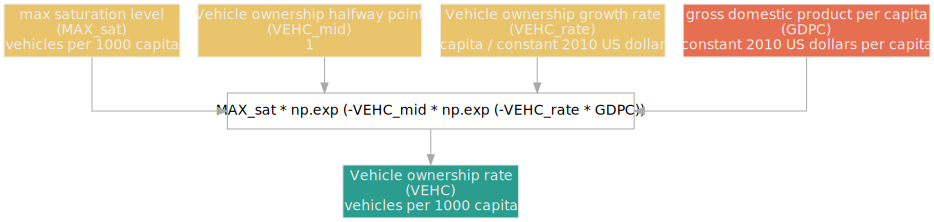

In [6]:
model.draw()

In [7]:
res = model.run(data_dict)

In [8]:
scores = score_model(model, data_dict)

In [9]:
scores.keys()

dict_keys(['score_by_Variable', 'score_by_ISO', 'score_by_ISO_Variable'])

# draft

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [123]:
df = (
    pd.concat([res['VEHC'].to_frame(name='Value').assign(type='model'),
               data_dict['VEHC'].to_frame(name='Value').assign(type='measure')])
      .reset_index()
      .merge(scores['score_by_ISO'].reset_index(), on='ISO')
      .astype({'Year': int})
)

In [125]:
plot_df = df.pivot(index=['ISO', 'Year'], columns=['type'], values='Value').reset_index()

In [126]:
ISO_list = scores['score_by_ISO'].sort_values(by='r2').tail(6).index.tolist()

In [127]:
ISO_list

['IDN', 'COL', 'SVN', 'CHN', 'POL', 'MUS']

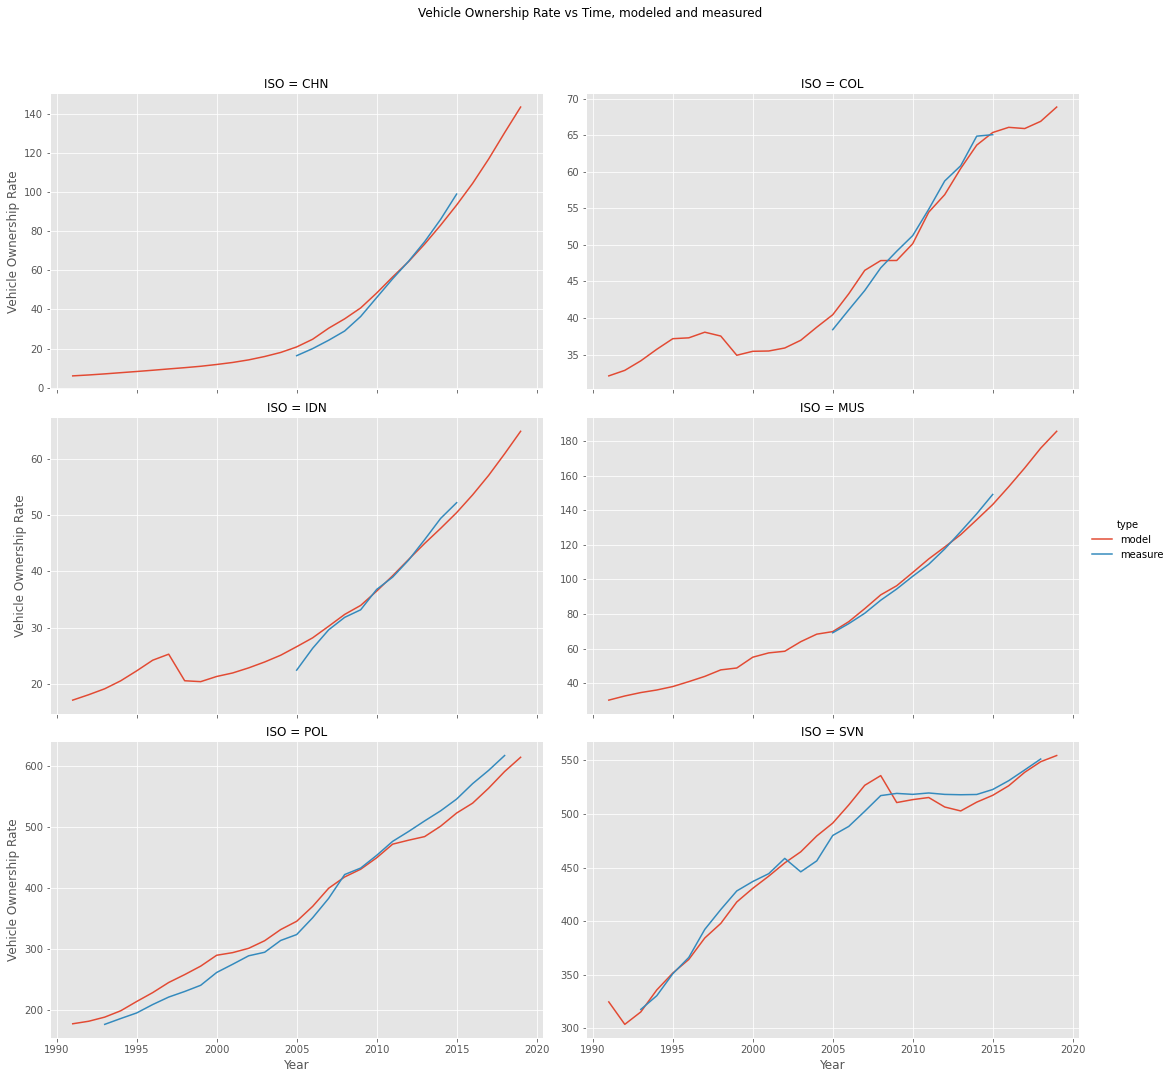

In [128]:
rp = sns.relplot(data=df.query(f'ISO in {ISO_list} and Year > 1990').rename(columns={'Value': 'Vehicle Ownership Rate'}),
            x='Year',
            y='Vehicle Ownership Rate',
            hue='type',
            col='ISO',
            col_wrap=2,
            kind='line',
            height=5,
            aspect=1.5,
            facet_kws=dict(sharey=False),
            )

rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Vehicle Ownership Rate vs Time, modeled and measured')

plt.show()

In [165]:
from ggdata.scripts import download
def get_WB_variables():
    '''To clean up'''

    to_download =  [
                    ('EN.ATM.PM25.MC.M3', 'PM2.5'),
                    ('NY.GDP.PCAP.KD', 'GDPC'),
    ]

    dfs = []

    for wb_indic, ggi_code in to_download:
        config = {'GGI_code': ggi_code, 'params': {'indicator': wb_indic}}
        
        df = download(API_name='WB', config=config, raw=False)
        
        dfs.append(df)

    df = pd.concat(dfs)
    df = df[~df.ISO.isin([''])]
    
    
    df.loc[df.Variable == 'PM2.5', 'Unit'] = 'micrograms/m3'


    return df

In [168]:
PM2_5 = get_WB_variables()[['ISO', 'Year', 'Value', 'Variable']]

PreProcessing: DONE
PreProcessing: DONE


In [170]:
VEHC = df.query("type =='measure'")[['ISO', 'Year', 'Value']].assign(Variable='VEHC')
df_1 = pd.concat([VEHC, PM2_5]).astype({'Year': int}).pivot(index=['ISO', 'Year'], columns='Variable', values='Value').dropna().reset_index()

In [176]:
df_1['VEH/GDP'] = df_1['VEHC'] / df_1['GDPC']

<AxesSubplot:xlabel='VEH/GDP', ylabel='PM2.5'>

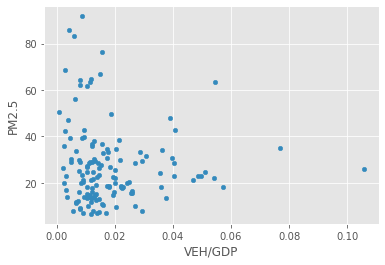

In [177]:
df_1.groupby('ISO').mean().plot(x='VEH/GDP', y='PM2.5', kind='scatter')

<AxesSubplot:xlabel='GDPC', ylabel='VEHC'>

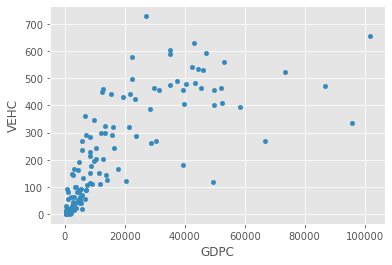

In [174]:
df_1.groupby('ISO').mean().plot(x='GDPC', y='VEHC', kind='scatter')

<AxesSubplot:xlabel='GDPC', ylabel='PM2.5'>

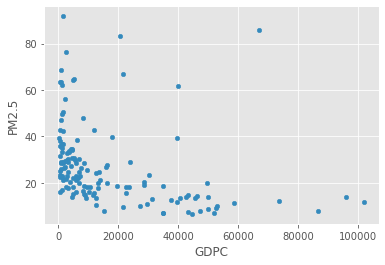

In [171]:
df_1.groupby('ISO').mean().plot(y='PM2.5', x='GDPC', kind='scatter')

<AxesSubplot:xlabel='VEHC', ylabel='PM2.5'>

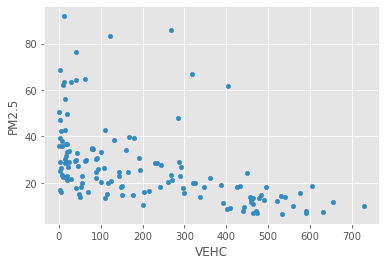

In [164]:
df_1.groupby('ISO').mean().plot(y='PM2.5', x='VEHC', kind='scatter')

# End of draft

In [37]:
for name, series in data_dict.items():
    series.to_csv(f'data/VEHC/{name}.csv')

In [13]:
from ggmodel_dev.projection import *
import plotly.express as px

In [21]:

model_dictionnary = {
    'VEHC_model': model
}


In [61]:
def run_scenario(data_dict, MAX_sat=1000, GDPC_rate=1.05):
    
    data_dict = data_dict.copy()
    
    print(data_dict['MAX_sat'])

    data_dict['MAX_sat'] = pd.Series(data=data_dict['MAX_sat'].values[0], index=data_dict['GDPC'].index, name='MAX_sat')
    

    scenario_projection_dict = {
        'MAX_sat': lambda x: apply_target_projection(x, MAX_sat),
        'GDPC': lambda x: apply_annual_rate_projection(x, GDPC_rate),
    }
    
    data_dict = run_projection(scenario_projection_dict, data_dict)

    results = model_dictionnary['VEHC_model'].run(data_dict)

    return  results     
    


In [62]:
def run_all_scenarios_VEHC(data_dict, ISO, args_dict_1, args_dict_2):
    scenarios_results = {}
    data_dict = {k: v.loc[[ISO]] for k, v in data_dict.items()}
    
    
    scenarios_results['BAU'] = run_scenario(data_dict, MAX_sat=data_dict['MAX_sat'], GDPC_rate=1.02)
    scenarios_results['scenario_one'] = run_scenario(data_dict, **args_dict_1)
    scenarios_results['scenario_two'] = run_scenario(data_dict,**args_dict_2)
    
    return scenarios_results


In [64]:
run_all_scenarios_VEHC(data_dict, 'FRA', {'GDPC_rate': 1.05, 'MAX_sat':500}, {'GDPC_rate': 1.05, 'MAX_sat':700})['scenario_one']

ISO
FRA    650.436713
Name: MAX_sat, dtype: float64
ISO
FRA    650.436713
Name: MAX_sat, dtype: float64
ISO
FRA    650.436713
Name: MAX_sat, dtype: float64


{'GDPC': ISO  Year
 FRA  2000     38309.442739
      2001     38786.085807
      2002     38942.281217
      2003     38985.535854
      2004     39794.635506
      2005     40152.692860
      2006     40850.355530
      2007     41582.799705
      2008     41456.483420
      2009     40058.679760
      2010     40638.334004
      2011     41329.035361
      2012     41258.274731
      2013     41282.990800
      2014     41480.769608
      2015     41793.544712
      2016     42140.036880
      2017     43015.210642
      2018     43720.026343
      2019     45906.027660
      2020     48201.329043
      2021     50611.395495
      2022     53141.965270
      2023     55799.063533
      2024     58589.016710
      2025     61518.467546
      2026     64594.390923
      2027     67824.110469
      2028     71215.315993
      2029     74776.081792
      2030     78514.885882
      2031     82440.630176
      2032     86562.661685
      2033     90890.794769
      2034     95435.334507
 